# Modelling

Feature engineering, model training, tuning, selection and explanability.

# 0. Load Packages and Define Helper Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, uniform
from preprocessing import preprocess_df, get_amenities
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression, Lasso # baseline
from sklearn.ensemble import RandomForestRegressor #good
from xgboost import XGBRegressor #good
from lightgbm import LGBMRegressor # goodest

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [38]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
set_config(display="diagram")
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from keras import backend
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

In [3]:
def fit_and_score(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'],n_jobs=2, verbose=1, cv = 5) 
    
    # Test metrics
    pred_test= model.predict(X_test)
    test_MSE = mean_squared_error(y_test, pred_test)
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')
    print('Test R-sq', round(model.score(X_test, y_test),4))
    print('Test MSE:', round(test_MSE,4))
    
    return model


def random_search_pipe(model, grid, X_train, y_train):
    
    search = RandomizedSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

def grid_search_pipe(model, grid, X_train, y_train):
    
    search = GridSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

In [4]:
def check_impact(df):
    
    print('Check accuracy at this step...')
    
    random_state = 12

    dep_var = ['price_log']
    to_drop = ['id', 'host_id', 'property_type', 'price', 'host_since', 'first_review', 'last_review']

    X = df.fillna(0).drop(dep_var + to_drop, axis = 1)
    y = df['price_log'].ravel()

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state = random_state)

    # Get numeric and categorical columns
    num_cols = list(X.select_dtypes(include=np.number).columns)
    cat_cols = list(set(X.columns)-set(X[num_cols].columns))

    # Preprocess
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols ),
            ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
        ]
        , remainder='passthrough'
    )

    
    lgbm_best = Pipeline([('preprocess', preprocessor),
                    ('regressor', LGBMRegressor(random_state = random_state,
                                               boosting_type = 'gbdt',
                                               colsample_bytree = 0.5,
                                               max_bin = 10,
                                               max_depth = 12,
                                               n_estimators = 350,
                                               num_leaves = 30,
                                               subsample = 0.50))
                   ])


    model = fit_and_score(model = lgbm_best, 
                                 X_train = X_train, 
                                 X_test = X_test,
                                 y_train = y_train,
                                 y_test = y_test)
    
    print('')
    print('Shape of X: {}'.format(np.shape(X)))
    

# 1. Load and Preprocess

In [5]:
data = pd.read_csv('data/listings.csv.gz')
df = preprocess_df(data = data, verbose = True)

Columns dropped ['listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_about', 'host_picture_url', 'calendar_last_scraped', 'license', 'host_url', 'host_thumbnail_url', 'host_verifications', 'name', 'description', 'neighborhood_overview', 'host_name', 'calendar_updated', 'bathrooms', 'host_neighbourhood', 'neighbourhood', 'host_listings_count', 'beds', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'neighbourhood_cleansed']
Before removing inactive listings, length = 66641
After removing inactive listings, length = 33046
After removing price = 0 listings, length = 33037
Features bathroom_num and bathroom_sharing extracted.
Int and float mv filled with 0, object m

In [6]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'bathroom_num', 'bathroom_sharing', 'price_log'],
      dtype='object')

In [7]:
df = get_amenities(data = df, 
                   num_amenities =80, # best is to call 80 amenities and select from there
                  verbose = True)

[('wifi', 32096), ('essentials', 31414), ('smoke alarm', 30603), ('heating', 29750), ('kitchen', 29321), ('hangers', 28388), ('long term stays allowed', 28070), ('iron', 27868), ('washer', 26852), ('hair dryer', 26387), ('hot water', 25305), ('shampoo', 23394), ('carbon monoxide alarm', 22656), ('dedicated workspace', 22473), ('dishes and silverware', 21126), ('cooking basics', 20499), ('refrigerator', 20424), ('bed linens', 18340), ('tv', 17925), ('microwave', 17588), ('oven', 17256), ('stove', 15436), ('dryer', 14012), ('first aid kit', 12522), ('fire extinguisher', 12352), ('coffee maker', 11651), ('dishwasher', 11275), ('private entrance', 9889), ('extra pillows and blankets', 9725), ('luggage dropoff allowed', 8066), ('host greets you', 7248), ('lockbox', 7143), ('bathtub', 7013), ('elevator', 6878), ('free parking on premises', 6310), ('shower gel', 6301), ('paid parking off premises', 5864), ('hot water kettle', 5738), ('backyard', 5698), ('free street parking', 5674), ('lock on

In [8]:
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_outdoor dining area,amenities_children’s books and toys,amenities_cleaning before checkout,amenities_clothing storage,amenities_clothing storage: closet,amenities_mini fridge,amenities_private fenced garden or backyard,amenities_building staff,amenities_paid street parking off premises,amenities_nespresso machine
1,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,0,0,0,0,0,0,0,0,0
4,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,0,0,0,0,0,0,0,0,0
9,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,0,1,0,0,0,1,0,0,0
11,38995,167281,2020-02-21,0,1.0,1,1,0.0,51.47860,-0.06114,...,0,0,0,0,0,0,0,0,0,0
14,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df['room_type'].value_counts()

Entire home/apt    20083
Private room       12646
Shared room          142
Hotel room           139
Name: room_type, dtype: int64

## 1.1 Baseline Before Feature Engineering

In [10]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.7s finished


Train R-sq 0.8698
Train MSE: 0.0813

CV R-sq 0.7841
CV MSE: 0.1348

Test R-sq 0.7954
Test MSE: 0.1225

Shape of X: (33010, 113)


# 2. Feature Engineering

## 2.1 Host Duration

In [11]:
# Last scraped date = 2021-12-07 (7th Dec)
df['host_duration'] = (pd.to_datetime('2021-12-10') - df['host_since']).dt.days

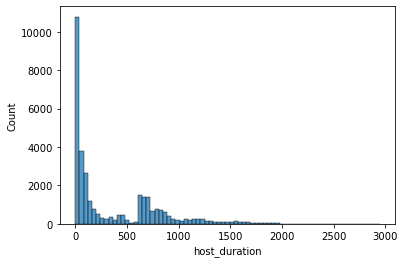

In [12]:
sns.histplot(df['host_duration'])
plt.show()

In [13]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.3s finished


Train R-sq 0.8701
Train MSE: 0.0811

CV R-sq 0.7861
CV MSE: 0.1336

Test R-sq 0.7954
Test MSE: 0.1225

Shape of X: (33010, 114)


## 2.2 managed_property

- Binary (0,1). 1 if properties managed by host id exceed the 95th percentile.

In [14]:
# Understand how many properties are potentially property managed

percentiles=[0.80,0.85,0.90,0.95]
percentile_rooms=[]
room_above=[]

for p in percentiles:
   percentile_rooms.append(df.host_id.value_counts().quantile(p))

print('Understand managed property percentiles beyond P75\n')
print(pd.DataFrame({'percentile':percentiles,'rooms_threshold':percentile_rooms}))

property_count=pd.DataFrame(df.groupby(['host_id'])['host_id'].count())
property_count.columns=['properties']
print('*****EXTRACT PROPERTIES MANAGED BY HOST ID *****')
property_count

Understand managed property percentiles beyond P75

   percentile  rooms_threshold
0        0.80              1.0
1        0.85              2.0
2        0.90              2.0
3        0.95              3.0
*****EXTRACT PROPERTIES MANAGED BY HOST ID *****


,properties
host_id,
4775,7
5653,1
6774,3
9323,1
10657,2
...,...
433334823,1
433435234,2
433572694,1


In [15]:
property_count['prop_managed']=property_count['properties'].map(lambda x: 1 if x>=percentile_rooms[3] else 0)
df=pd.merge(df,property_count,on='host_id',how='inner')
df.prop_managed.value_counts()

0    22496
1    10514
Name: prop_managed, dtype: int64

In [16]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.2s finished


Train R-sq 0.8743
Train MSE: 0.0775

CV R-sq 0.7879
CV MSE: 0.1309

Test R-sq 0.7871
Test MSE: 0.1336

Shape of X: (33010, 116)


## 2.3 Occupancy Rate

- short term proxy: avail30
- mid term proxy: avail60-90
- long term proxy: avail365

In [17]:
cols=['availability_30','availability_60', 'availability_90','availability_365']
df[cols].describe()

,availability_30,availability_60,availability_90,availability_365
count,33010.000000,33010.000000,33010.000000,33010.000000
mean,6.882187,18.561527,31.615177,121.371191
std,9.251464,20.881292,33.341793,134.103803
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,7.000000,17.000000,66.000000
75%,12.000000,37.000000,65.000000,248.000000
max,30.000000,60.000000,90.000000,365.000000


In [18]:
df['occ_30D']=1-round(df.availability_30/30,2)
df['occ_6090D']=((1-round(df.availability_60/60,2))+(1-round(df.availability_90/90,2)))/2
df['occ_365']=1-round(df.availability_365/365,2)

df=df.drop(cols,axis=1) # do not drop

In [19]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'amenities_private fenced garden or backyard',
       'amenities_building staff',
       'amenities_paid street parking off premises',
       'amenities_nespresso machine', 'host_duration', 'properties',
       'prop_managed', 'occ_30D', 'occ_6090D', 'occ_365'],
      dtype='object', length=123)

In [20]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.3s finished


Train R-sq 0.873
Train MSE: 0.0783

CV R-sq 0.7854
CV MSE: 0.1325

Test R-sq 0.7872
Test MSE: 0.1335

Shape of X: (33010, 115)


## 2.4 Location Variables

In [21]:
# Load computed location features
location_features = ['station', 'station_dist','walking_distance']
df = df.merge(pd.read_csv('computed_features/london_nearest_tube.csv')[['id']+location_features],left_on='id', right_on='id',how='left')
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_nespresso machine,host_duration,properties,prop_managed,occ_30D,occ_6090D,occ_365,station,station_dist,walking_distance
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,634,1,0,1.0,1.000,0.99,South Kensington,805.406363,0.0
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,635,3,1,1.0,1.000,1.00,Brent Cross,302.665825,1.0
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,692,3,1,0.9,0.960,0.99,Brent Cross,346.564965,1.0
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,0,630,3,1,1.0,1.000,1.00,Brent Cross,361.025714,1.0
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,485,1,0,0.8,0.335,0.07,Shepherds Bush Market,449.743591,3.0


## 2.5 Sentiment

In [22]:
############## Add sentiment features #################
import pandas as pd
df_sentiment = pd.read_csv('computed_features/nc_eng_with_sent.csv')
# df_sentiment = df_sentiment.groupby('listing_id').mean()
# df_sentiment = df_sentiment.reset_index()
df=pd.merge(df,df_sentiment,left_on='id', right_on='listing_id',how='left')
df = df.drop(['listing_id'], axis = 1)
df = df.fillna(df.mean())
df.head()

,id_x,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,walking_distance,Unnamed: 0,id_y,reviewer_id,comments_len,key_reviewer,negative,neutral,positive,compound
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0.0,1.0,8.029375e+07,2.695406e+07,78.062500,0.075000,0.016000,0.682400,0.301550,0.900261
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,1.0,3.0,8.898858e+07,3.434179e+07,61.970588,0.127451,0.011020,0.607324,0.381667,0.941062
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,1.0,10.0,1.066726e+08,3.536433e+07,71.552239,0.074627,0.007433,0.627463,0.365134,0.961803
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,1.0,16621.0,4.596262e+08,1.034197e+08,44.500000,0.136364,0.003682,0.558909,0.437409,0.953786
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,3.0,7.0,3.235218e+08,8.901368e+07,86.068966,0.000000,0.007931,0.707483,0.284621,0.927310


# 3. Feature selection

In [23]:
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.preprocessing import LabelEncoder


def regression_scores(model, X_train, X_test, y_train, y_test):
    
     # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5) 
    
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')

def run_model(X, y):
    
    random_state = 42
    
    # Automatic label encoding
    le = LabelEncoder()
    for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = le.fit_transform(X[column_name])
        else:
            pass

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    
    # Train Model
    rf = RandomForestRegressor(n_jobs = -1, random_state = random_state)
    
    # Fit Model
    rf.fit(X_train, y_train)

    # Score model on test set
    regression_scores(rf, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [24]:
## LGBMReressor

from numpy import sort
from sklearn.feature_selection import SelectFromModel
#Get a function to generally see feature importance
def run_lgbm(X,y):
    random_state = 42
    
     # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    lgbm = LGBMRegressor(n_jobs=-1,random_state=random_state)
    lgbm.fit(X_train,y_train)
    print('Scores run on full number of features')
    regression_scores(lgbm, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

    # plot feature importance
    # choice of gain, weighted or cover
    # use gain; weighted might give too much bias to numerical or high cardinality. 
    # this post explains it well:
    # https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
    plot_importance(lgbm, importance_type="gain")
    plt.show()
    
    ## From prof's sample code
    # The following block of codes will try to use importance score for features selection

    # Fit model using each importance as a threshold
    thresholds = sort(lgbm.feature_importances_) # sort the importance score

    # select feaures by using importance score as threshold
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(lgbm, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = LGBMRegressor(n_jobs=-1, random_state = 42)
        selection_model.fit(select_X_train, y_train)
        # eval model
        cv_score = cross_validate(selection_model, select_X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5)
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        #test_MSE = mean_squared_error(y_train, y_pred)
        #print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
        #print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
        print("Thresh=%.3f, n=%d, CV MSE: %.2f" % (thresh, select_X_train.shape[1], round(-np.mean(cv_score['test_neg_mean_squared_error']),4)))
    
    return selection

In [52]:
## modify the func to run at threshold = xx
import eli5
from eli5.sklearn import PermutationImportance

## LGBMReressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

from numpy import sort
from sklearn.feature_selection import SelectFromModel

#Re-write function to accept threshold value and also output the test MSE on the selected subset
def thresh_run_lgbm(X,y,thresh):
    random_state = 42
    
     # Automatic label encoding
    le = LabelEncoder()
    for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = le.fit_transform(X[column_name])
        else:
            pass
        
     # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    lgbm = LGBMRegressor(n_jobs=-1,random_state=random_state)
    lgbm.fit(X_train,y_train)
    

    # Fit model using each importance as a threshold
    thresholds = sort(lgbm.feature_importances_) # sort the importance score

    # select features using threshold
    selection = SelectFromModel(lgbm, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = LGBMRegressor(n_jobs=-1, random_state = 42)
    selection_model.fit(select_X_train, y_train)
    # eval model on cv
    cv_score = cross_validate(selection_model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
   
   # CV_MSE = mean_squared_error(y_test, cv_score)
    
    print('Score from selected subset of features')
    #Score of subset features (not all features)
    regression_scores(selection_model, X_train = select_X_train, X_test = select_X_test, y_train = y_train, y_test = y_test)
    
    print("Thresh=%.3f, n=%d, CV:%.2f" % (thresh, select_X_train.shape[1],round(-np.mean(cv_score['test_neg_mean_squared_error']),4)))
    
   
    ##carry on from selection 
    include = selection.get_support()
    headers = X_all.columns

    fs = pd.DataFrame({'cols':headers,'include':include})
    filters = (fs.include==True)
    selected_col = fs[filters].cols.tolist()
    
    return selected_col

In [53]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [54]:
drop_cols=['id_x','host_id','host_has_profile_pic','price','price_log','id_y','reviewer_id','host_since','key_reviewer','first_review','last_review']
X_all=df.drop(drop_cols,axis=1)
y_all=df['price_log']

In [55]:
lgbm_col = thresh_run_lgbm(X_all,y_all,5)

Score from selected subset of features
Train R-sq 0.8357
Train MSE: 0.1011

CV R-sq 0.7801
CV MSE: 0.1353

Thresh=5.000, n=68, CV:0.14


In [56]:
fs_cols=lgbm_col
df_fs= df[fs_cols]
df.columns

Index(['id_x', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'walking_distance', 'Unnamed0', 'id_y', 'reviewer_id', 'comments_len',
       'key_reviewer', 'negative', 'neutral', 'positive', 'compound'],
      dtype='object', length=135)

# 4. Models

In [57]:
# Format columns
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [58]:
df.columns.tolist()

['id_x',
 'host_id',
 'host_since',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'bathroom_num',
 'bathroom_sharing',
 'price_log',
 'amenities_wifi',
 'amenities_essentials',
 'amenities_smokealarm',
 'amenities_heating',
 'amenities_kitchen',
 'amenities_hangers',
 'amenities_longtermstaysallowed',
 'amenities_iron',
 'amenities_washer',
 'amenities

In [59]:
sentiment_features = [   'comments_len',
                         'neutral',
                         'negative',
                         'positive']

features_selected = ['host_total_listings_count',
                         'neighbourhood_group_cleansed',
                         'latitude',
                         'longitude',
                         'room_type',
                         'accommodates',
                         'bedrooms',
                         'minimum_nights',
                         'maximum_nights',
                         'minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm',
                         'number_of_reviews',
                         'number_of_reviews_ltm',
                         'number_of_reviews_l30d',
                         'review_scores_rating',
                         'review_scores_accuracy',
                         'review_scores_cleanliness',
                         'review_scores_checkin',
                         'review_scores_communication',
                         'review_scores_location',
                         'review_scores_value',
                         'reviews_per_month',
                         'bathroom_num',
                         'bathroom_sharing',
                        'amenities_wifi',
                        'amenities_essentials',
                        'amenities_smokealarm',
                        'amenities_heating',
                        'amenities_kitchen',
                        'amenities_hangers',
                        'amenities_longtermstaysallowed',
                        'amenities_iron',
                        'amenities_washer',
                        'amenities_hairdryer',
                        'amenities_hotwater',
                        'amenities_shampoo',
                        'amenities_carbonmonoxidealarm',
                        'amenities_dedicatedworkspace',
                        'amenities_dishesandsilverware',
                        'amenities_cookingbasics',
                        'amenities_refrigerator',
                        'amenities_bedlinens',
                        'amenities_tv',
                        'amenities_microwave',
                        'amenities_oven',
                        'amenities_stove',
                        'amenities_dryer',
                        'amenities_firstaidkit',
                        'amenities_fireextinguisher',
                        'amenities_coffeemaker',
                        'amenities_dishwasher',
                        'amenities_privateentrance',
                        'amenities_extrapillowsandblankets',
                        'amenities_luggagedropoffallowed',
                        'amenities_hostgreetsyou',
                        'amenities_lockbox',
                        'amenities_bathtub',
                        'amenities_elevator',
                        'amenities_freeparkingonpremises',
                        'amenities_showergel',
                        'amenities_paidparkingoffpremises',
                        'amenities_hotwaterkettle',
                        'amenities_backyard',
                        'amenities_freestreetparking',
                        'amenities_lockonbedroomdoor',
                        'amenities_cabletv',
                        'amenities_patioorbalcony',
                        'amenities_freezer',
                        'amenities_tvwithstandardcable',
                        'amenities_cleaningproducts',
                        'amenities_toaster',
                        'amenities_diningtable',
                        'amenities_wineglasses',
                        'amenities_roomdarkeningshades',
                        'amenities_bodysoap',
                        'amenities_breakfast',
                        'amenities_dryingrackforclothing',
                        'amenities_singlelevelhome',
                        'amenities_securitycamerasonproperty',
                        'amenities_conditioner',
                        'amenities_indoorfireplace',
                        'amenities_portablefans',
                        'amenities_ethernetconnection',
                        'amenities_outdoorfurniture',
                        'amenities_laundromatnearby',
                        'amenities_packnplaytravelcrib',
                        'amenities_crib',
                        'amenities_airconditioning',
                        'amenities_highchair',
                        'amenities_bakingsheet',
                        'amenities_bbqgrill',
                        'amenities_paidparkingonpremises',
                        'amenities_privatepatioorbalcony',
                        'amenities_centralheating',
                        'amenities_outdoordiningarea',
                        'amenities_childrensbooksandtoys',
                        'amenities_cleaningbeforecheckout',
                        'amenities_clothingstorage',
                        'amenities_clothingstoragecloset',
                        'amenities_minifridge',
                        'amenities_privatefencedgardenorbackyard',
                        'amenities_buildingstaff',
                        'amenities_paidstreetparkingoffpremises',
                        'amenities_nespressomachine',
                         'host_duration',
                         'properties',
                         'occ_30D',
                         'occ_6090D',
                         'occ_365'] + location_features + sentiment_features

In [60]:
random_state = 12

dep_var = ['price_log']
#to_drop = ['id', 'host_id', 'property_type', 'price', 'host_since', 'first_review', 'last_review']

X = df[features_selected]
y = df['price_log'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state = random_state)

# Get numeric and categorical columns
num_cols = list(X.select_dtypes(include=np.number).columns)
cat_cols = list(set(X.columns)-set(X[num_cols].columns))

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))
print(cat_cols)

X shape: (33010, 116)
y shape: (33010,)
['bathroom_sharing', 'station', 'room_type']


In [61]:
# Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols ),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
    ]
    , remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['host_total_listings_count',
                                  'neighbourhood_group_cleansed', 'latitude',
                                  'longitude', 'accommodates', 'bedrooms',
                                  'minimum_nights', 'maximum_nights',
                                  'minimum_nights_avg_ntm',
                                  'maximum_nights_avg_ntm', 'number_of_reviews',
                                  'number_of_reviews_ltm',
                                  'number_of_reviews_l30d',
                                  'review_...
                                  'review_scores_value', 'reviews_per_month',
                                  'bathroom_num', 'amenities_wifi',
                                  'amenities_essentials',
                                  'amenities_smokealarm', 'amenities_heating',
                                  'amenities_kitchen', 'amenities_hangers',
                                  'amenities_longtermstaysallowed',
                                  'amenities_iron', ...]),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['bathroom_sharing', 'station', 'room_type'])])

## Linear Regression (Baseline)

In [75]:
# Pipeline for One-Hot Encoding

linreg_pipe = Pipeline([('preprocess', preprocessor),
                    ('regressor', LinearRegression())
                   ])

linreg_model = fit_and_score(model = linreg_pipe, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.0s finished


Train R-sq 0.7349
Train MSE: 0.1636

CV R-sq 0.7161
CV MSE: 0.1753

Test R-sq 0.7048
Test MSE: 0.1853


## Neural Network

In [70]:
X_train_trfm = X_train.drop(['station'],axis=1)
X_test_trfm = X_test.drop(['station'],axis=1)

X_train_trfm = pd.get_dummies(X_train_trfm, columns=['bathroom_sharing', 'room_type'])
X_test_trfm = pd.get_dummies(X_test_trfm, columns=['bathroom_sharing', 'room_type'])

stdscaler = StandardScaler()
X_train_trfm = stdscaler.fit_transform(X_train_trfm)
X_test_trfm = stdscaler.transform(X_test_trfm)

X_train_trfm = pd.DataFrame(X_train_trfm)
X_train_trfm = X_train_trfm.set_axis(X_train_trfm.columns, axis=1, inplace=False)
X_test_trfm = pd.DataFrame(X_test_trfm)
X_test_trfm = X_test_trfm.set_axis(X_test_trfm.columns, axis=1, inplace=False)

In [71]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def r2(y_true, y_pred):
    SS_res =  backend.sum(backend.square( y_true-y_pred )) 
    SS_tot = backend.sum(backend.square( y_true - backend.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

In [74]:
X_train_trfm.shape

(26408, 120)

### Baseline NN

In [84]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(120, input_dim=120, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='he_normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_bl = baseline_model()
model_bl.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 120)               14520     
                                                                 
 dense_9 (Dense)             (None, 1)                 121       
                                                                 
Total params: 14,641
Trainable params: 14,641
Non-trainable params: 0
_________________________________________________________________


In [85]:
epoch=100
history_bl = model_bl.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Epoch 1/100
784/784 [==============================] - 2s 2ms/step - loss: 1.0853 - rmse: 0.6734 - r2: -1.0614 - val_loss: 0.3249 - val_rmse: 0.4356 - val_r2: 0.3644
Epoch 2/100
784/784 [==============================] - 1s 1ms/step - loss: 0.2869 - rmse: 0.3992 - r2: 0.4996 - val_loss: 0.2709 - val_rmse: 0.3895 - val_r2: 0.4801
Epoch 3/100
784/784 [==============================] - 1s 1ms/step - loss: 0.2232 - rmse: 0.3505 - r2: 0.6117 - val_loss: 0.2219 - val_rmse: 0.3560 - val_r2: 0.5743
Epoch 4/100
784/784 [==============================] - 1s 2ms/step - loss: 0.1900 - rmse: 0.3216 - r2: 0.6717 - val_loss: 0.2023 - val_rmse: 0.3325 - val_r2: 0.6141
Epoch 5/100
784/784 [==============================] - 1s 2ms/step - loss: 0.1741 - rmse: 0.3071 - r2: 0.7029 - val_loss: 0.1931 - val_rmse: 0.3283 - val_r2: 0.6345
Epoch 6/100
784/784 [==============================] - 1s 1ms/step - loss: 0.1632 - rmse: 0.2968 - r2: 0.7202 - val_loss: 0.1856 - val_rmse: 0.3166 - val_r2: 0.6455
Epoch 7/1

784/784 [==============================] - 1s 1ms/step - loss: 0.0850 - rmse: 0.2165 - r2: 0.8500 - val_loss: 0.1746 - val_rmse: 0.3124 - val_r2: 0.6759
Epoch 51/100
784/784 [==============================] - 1s 1ms/step - loss: 0.0840 - rmse: 0.2157 - r2: 0.8540 - val_loss: 0.1814 - val_rmse: 0.3189 - val_r2: 0.6595
Epoch 52/100
784/784 [==============================] - 1s 2ms/step - loss: 0.0835 - rmse: 0.2156 - r2: 0.8536 - val_loss: 0.1743 - val_rmse: 0.3098 - val_r2: 0.6741
Epoch 53/100
784/784 [==============================] - 1s 2ms/step - loss: 0.0838 - rmse: 0.2150 - r2: 0.8533 - val_loss: 0.1839 - val_rmse: 0.3223 - val_r2: 0.6535
Epoch 54/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0829 - rmse: 0.2133 - r2: 0.8556 - val_loss: 0.1772 - val_rmse: 0.3180 - val_r2: 0.6644
Epoch 55/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0810 - rmse: 0.2124 - r2: 0.8583 - val_loss: 0.1836 - val_rmse: 0.3226 - val_r2: 0.6597
Epoch 56/100
784/

784/784 [==============================] - 1s 1ms/step - loss: 0.0697 - rmse: 0.1980 - r2: 0.8774 - val_loss: 0.1999 - val_rmse: 0.3300 - val_r2: 0.6218
Epoch 100/100
784/784 [==============================] - 1s 1ms/step - loss: 0.0678 - rmse: 0.1959 - r2: 0.8809 - val_loss: 0.1895 - val_rmse: 0.3258 - val_r2: 0.6452


In [102]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_bl.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_bl.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

In [90]:
mse_nn, rmse_nn, r2_nn = model_bl.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(history_bl.history['r2'][epoch-1],4))
print('Train MSE: ', round(history_bl.history['loss'][epoch-1],4))
print('Val R-sq: ', round(history_bl.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(history_bl.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

207/207 [==============================] - 0s 2ms/step - loss: 0.2069 - rmse: 0.3309 - r2: 0.6526
Train R-sq:  0.8809
Train MSE:  0.0678
Val R-sq:  0.6452
Val MSE:  0.1895
Test R-sq:  0.6526
Test MSE:  0.2069


### Deep NN

In [94]:
def deep_model():
    # create model
    model = Sequential()
    model.add(Dense(120, input_dim=120, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(60, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='he_normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_dp = deep_model()
model_dp.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 120)               14520     
                                                                 
 dense_14 (Dense)            (None, 60)                7260      
                                                                 
 dense_15 (Dense)            (None, 1)                 61        
                                                                 
Total params: 21,841
Trainable params: 21,841
Non-trainable params: 0
_________________________________________________________________


In [95]:
epoch=100
history_dp = model_dp.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Epoch 1/100
784/784 [==============================] - 2s 2ms/step - loss: 0.6299 - rmse: 0.5339 - r2: -0.0958 - val_loss: 0.2672 - val_rmse: 0.3938 - val_r2: 0.4871
Epoch 2/100
784/784 [==============================] - 1s 2ms/step - loss: 0.2377 - rmse: 0.3612 - r2: 0.5853 - val_loss: 0.2206 - val_rmse: 0.3546 - val_r2: 0.5830
Epoch 3/100
784/784 [==============================] - 1s 2ms/step - loss: 0.1943 - rmse: 0.3265 - r2: 0.6629 - val_loss: 0.1880 - val_rmse: 0.3220 - val_r2: 0.6468
Epoch 4/100
784/784 [==============================] - 1s 2ms/step - loss: 0.1750 - rmse: 0.3095 - r2: 0.6972 - val_loss: 0.1770 - val_rmse: 0.3137 - val_r2: 0.6659
Epoch 5/100
784/784 [==============================] - 1s 2ms/step - loss: 0.1621 - rmse: 0.2983 - r2: 0.7207 - val_loss: 0.1788 - val_rmse: 0.3187 - val_r2: 0.6593
Epoch 6/100
784/784 [==============================] - 1s 2ms/step - loss: 0.1571 - rmse: 0.2905 - r2: 0.7283 - val_loss: 0.1752 - val_rmse: 0.3127 - val_r2: 0.6661
Epoch 7/1

784/784 [==============================] - 2s 2ms/step - loss: 0.0503 - rmse: 0.1716 - r2: 0.9098 - val_loss: 0.2032 - val_rmse: 0.3332 - val_r2: 0.6183
Epoch 51/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0498 - rmse: 0.1714 - r2: 0.9112 - val_loss: 0.1868 - val_rmse: 0.3145 - val_r2: 0.6486
Epoch 52/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0490 - rmse: 0.1695 - r2: 0.9128 - val_loss: 0.1933 - val_rmse: 0.3255 - val_r2: 0.6338
Epoch 53/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0477 - rmse: 0.1679 - r2: 0.9151 - val_loss: 0.1920 - val_rmse: 0.3229 - val_r2: 0.6353
Epoch 54/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0480 - rmse: 0.1677 - r2: 0.9135 - val_loss: 0.1875 - val_rmse: 0.3209 - val_r2: 0.6411
Epoch 55/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0470 - rmse: 0.1662 - r2: 0.9155 - val_loss: 0.2001 - val_rmse: 0.3306 - val_r2: 0.6229
Epoch 56/100
784/

784/784 [==============================] - 2s 2ms/step - loss: 0.0313 - rmse: 0.1362 - r2: 0.9433 - val_loss: 0.2060 - val_rmse: 0.3343 - val_r2: 0.6127
Epoch 100/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0320 - rmse: 0.1381 - r2: 0.9425 - val_loss: 0.2066 - val_rmse: 0.3359 - val_r2: 0.6115


In [103]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_dp.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_dp.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

In [97]:
mse_nn, rmse_nn, r2_nn = model_dp.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(history_dp.history['r2'][epoch-1],4))
print('Train MSE: ', round(history_dp.history['loss'][epoch-1],4))
print('Val R-sq: ', round(history_dp.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(history_dp.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

207/207 [==============================] - 0s 1ms/step - loss: 0.2290 - rmse: 0.3497 - r2: 0.6107
Train R-sq:  0.9425
Train MSE:  0.032
Val R-sq:  0.6115
Val MSE:  0.2066
Test R-sq:  0.6107
Test MSE:  0.229


### Wide NN

In [98]:
def wide_model():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=120, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='he_normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_wd = wide_model()
model_wd.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 200)               24200     
                                                                 
 dense_17 (Dense)            (None, 1)                 201       
                                                                 
Total params: 24,401
Trainable params: 24,401
Non-trainable params: 0
_________________________________________________________________


In [99]:
epoch=100
history_wd = model_wd.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Epoch 1/100
784/784 [==============================] - 1s 1ms/step - loss: 0.7048 - rmse: 0.5711 - r2: -0.2780 - val_loss: 0.3191 - val_rmse: 0.4117 - val_r2: 0.3924
Epoch 2/100
784/784 [==============================] - 1s 1ms/step - loss: 0.2546 - rmse: 0.3779 - r2: 0.5539 - val_loss: 0.2296 - val_rmse: 0.3481 - val_r2: 0.5695
Epoch 3/100
784/784 [==============================] - 1s 1ms/step - loss: 0.1983 - rmse: 0.3302 - r2: 0.6606 - val_loss: 0.1908 - val_rmse: 0.3206 - val_r2: 0.6396
Epoch 4/100
784/784 [==============================] - 1s 2ms/step - loss: 0.1781 - rmse: 0.3100 - r2: 0.6914 - val_loss: 0.1845 - val_rmse: 0.3089 - val_r2: 0.6586
Epoch 5/100
784/784 [==============================] - 2s 2ms/step - loss: 0.1570 - rmse: 0.2935 - r2: 0.7270 - val_loss: 0.1692 - val_rmse: 0.2974 - val_r2: 0.6874
Epoch 6/100
784/784 [==============================] - 2s 2ms/step - loss: 0.1506 - rmse: 0.2871 - r2: 0.7396 - val_loss: 0.1762 - val_rmse: 0.3063 - val_r2: 0.6747
Epoch 7/1

784/784 [==============================] - 1s 2ms/step - loss: 0.0733 - rmse: 0.1991 - r2: 0.8723 - val_loss: 0.1781 - val_rmse: 0.3118 - val_r2: 0.6618
Epoch 51/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0697 - rmse: 0.1951 - r2: 0.8771 - val_loss: 0.1848 - val_rmse: 0.3206 - val_r2: 0.6527
Epoch 52/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0710 - rmse: 0.1978 - r2: 0.8745 - val_loss: 0.1750 - val_rmse: 0.3160 - val_r2: 0.6681
Epoch 53/100
784/784 [==============================] - 2s 2ms/step - loss: 0.0735 - rmse: 0.1972 - r2: 0.8731 - val_loss: 0.1721 - val_rmse: 0.3115 - val_r2: 0.6722
Epoch 54/100
784/784 [==============================] - 1s 2ms/step - loss: 0.0696 - rmse: 0.1964 - r2: 0.8755 - val_loss: 0.1738 - val_rmse: 0.3119 - val_r2: 0.6670
Epoch 55/100
784/784 [==============================] - 1s 2ms/step - loss: 0.0715 - rmse: 0.1958 - r2: 0.8747 - val_loss: 0.1740 - val_rmse: 0.3129 - val_r2: 0.6703
Epoch 56/100
784/

784/784 [==============================] - 1s 2ms/step - loss: 0.0531 - rmse: 0.1743 - r2: 0.9062 - val_loss: 0.1933 - val_rmse: 0.3286 - val_r2: 0.6293
Epoch 100/100
784/784 [==============================] - 1s 2ms/step - loss: 0.0542 - rmse: 0.1758 - r2: 0.9032 - val_loss: 0.1905 - val_rmse: 0.3237 - val_r2: 0.6336


In [104]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_wd.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_wd.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

In [101]:
mse_nn, rmse_nn, r2_nn = model_wd.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(history_wd.history['r2'][epoch-1],4))
print('Train MSE: ', round(history_wd.history['loss'][epoch-1],4))
print('Val R-sq: ', round(history_wd.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(history_wd.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

207/207 [==============================] - 0s 2ms/step - loss: 0.2173 - rmse: 0.3386 - r2: 0.6320
Train R-sq:  0.9032
Train MSE:  0.0542
Val R-sq:  0.6336
Val MSE:  0.1905
Test R-sq:  0.632
Test MSE:  0.2173


### 5.3 Actual vs Predicted

In [117]:
import matplotlib.cm as cm
sns.set_style("whitegrid")
import matplotlib.colors as mcolors

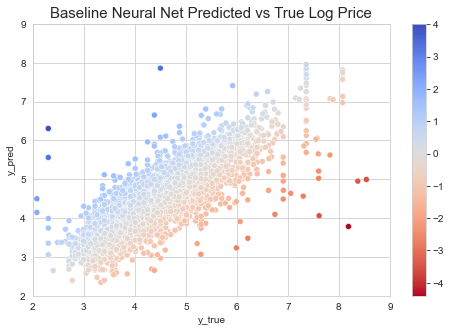

In [119]:
pred = model_bl.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Baseline Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

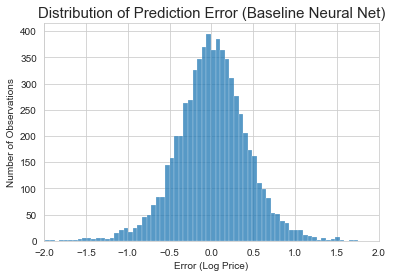

In [120]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Baseline Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

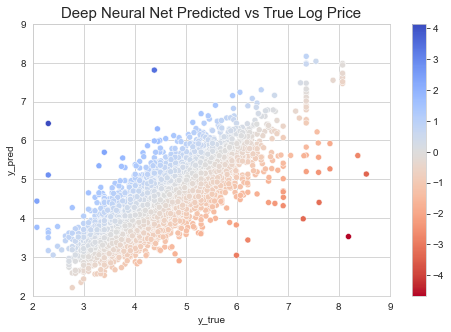

In [121]:
pred = model_dp.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Deep Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

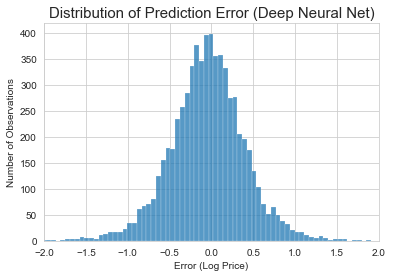

In [122]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Deep Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

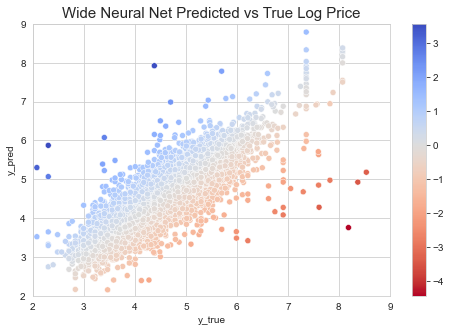

In [123]:
pred = model_wd.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Wide Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

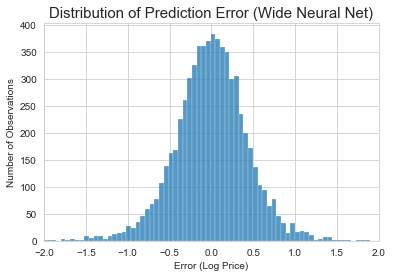

In [124]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Wide Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()